## 1. 필요한 패키지 불러오기

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgbm

from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
import datetime
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler


## 2. 데이터 불러오기

### 데이터 설명
- train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
- test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
- sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.

### 변수 설명

- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

### csv파일 불러오기

In [45]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [46]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [47]:
y = data['price']
sub_id = sub["id"]
del data['price']

In [48]:
train_len = len(data)
data = pd.concat((data, sub), axis=0).reset_index().drop(columns=["index", "id"])
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 데이터 훑어보기

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  object 
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_l

In [50]:
data.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,291.675348,1971.055016,84.741943,98077.897968,47.560121,-122.213786,1987.242664,12774.529089
std,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,442.645882,29.372398,402.452836,53.489890,0.138615,0.140833,685.579479,27334.995914
min,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.125000,2370.000000,10085.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


앞으로의 전처리 과정을 정리하겠습니다.
1. 결측값이 존재하는지 확인하고 존재하면 결측값을 제거하겠습니다.
2. Feature Engineering을 통하여 파생변수를 생성하겠습니다.
3. 연속형 변수들은 표준화(Standard scaling)을 해주겠습니다.
4. 변수간의 상관관계를 시각화하겠습니다.

## 3. 데이터 전처리및 시각화

### 1. 결측값 확인하기

<AxesSubplot:>

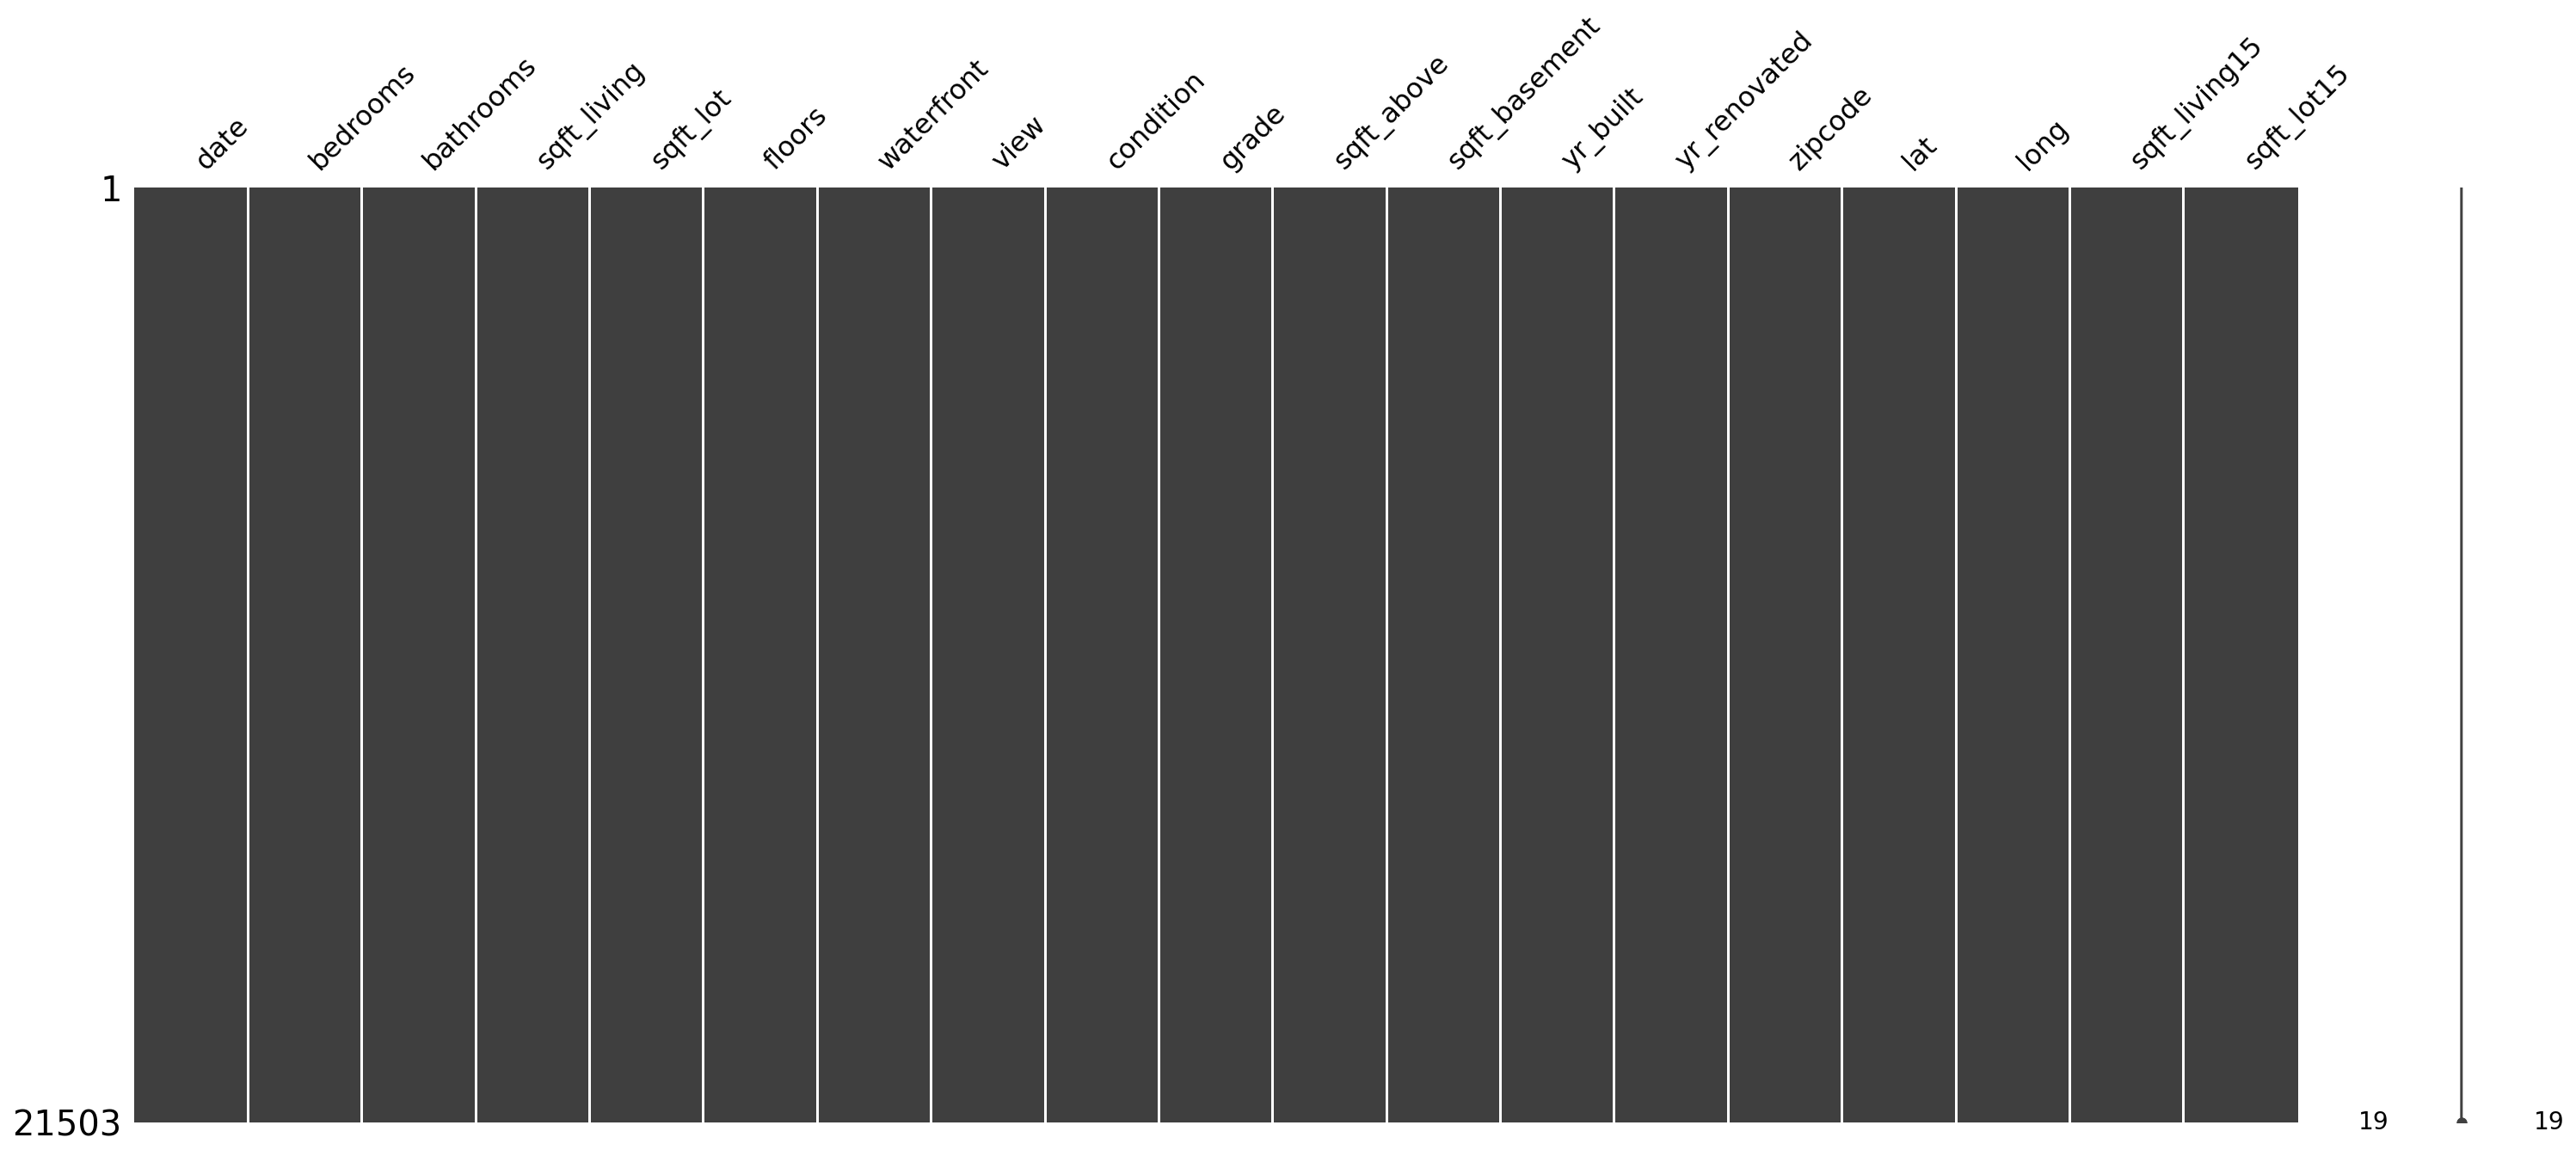

In [51]:
msno.matrix(data)

In [52]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 2. 변수 재조합하기

#### 날짜데이터 년월 변환

In [53]:
data['date'] = data['date'].apply(lambda x : str(x[:8]))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 침실 수와 화장실 수 합치기

In [54]:
data["bed_bath"] = data["bedrooms"] + data["bathrooms"]
data["bed_bath"] = data["bed_bath"].apply(lambda x : round(x))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bed_bath
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4


#### 총 평방피트 만들기

In [55]:
data["sqft_total"] = data["sqft_above"] + data["sqft_basement"]
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bed_bath,sqft_total
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,47.5112,-122.257,1340,5650,4,1180
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,...,0,1933,0,98028,47.7379,-122.233,2720,8062,3,770
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,...,0,1987,0,98074,47.6168,-122.045,1800,7503,5,1680
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,...,0,1995,0,98003,47.3097,-122.327,2238,6819,5,1715
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,...,0,1963,0,98198,47.4095,-122.315,1650,9711,4,1060


#### 재건축 연도 변수를 재건축 여부 변수로 변환

In [56]:
data["renovated_T/F"] = data["yr_renovated"].apply(lambda x: 1 if x > 0 else 0)
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bed_bath,sqft_total,renovated_T/F
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,...,1955,0,98178,47.5112,-122.257,1340,5650,4,1180,0
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,...,1933,0,98028,47.7379,-122.233,2720,8062,3,770,0
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,...,1987,0,98074,47.6168,-122.045,1800,7503,5,1680,0
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,...,1995,0,98003,47.3097,-122.327,2238,6819,5,1715,0
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,...,1963,0,98198,47.4095,-122.315,1650,9711,4,1060,0


#### 부지와 주거공간 평방면적의 비율

In [57]:
data["sqft_ratio"] = data["sqft_living"] / data["sqft_lot"]
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bed_bath,sqft_total,renovated_T/F,sqft_ratio
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,...,0,98178,47.5112,-122.257,1340,5650,4,1180,0,0.208850
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,...,0,98028,47.7379,-122.233,2720,8062,3,770,0,0.077000
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,...,0,98074,47.6168,-122.045,1800,7503,5,1680,0,0.207921
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,...,0,98003,47.3097,-122.327,2238,6819,5,1715,0,0.251503
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,...,0,98198,47.4095,-122.315,1650,9711,4,1060,0,0.109155


### 3. 연속형 변수들은 정규화(Log scaling)

In [58]:
scalling_columns = ["sqft_living15", "sqft_lot15", "sqft_total", "sqft_ratio", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement"]


for columns in scalling_columns:
    data[columns] = np.log1p(data[columns])

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bed_bath,sqft_total,renovated_T/F,sqft_ratio
0,20141013,3,1.00,7.074117,8.639588,1.0,0,0,3,7,...,0,98178,47.5112,-122.257,7.201171,8.639588,4,7.074117,0,0.189669
1,20150225,2,1.00,6.647688,9.210440,1.0,0,0,3,6,...,0,98028,47.7379,-122.233,7.908755,8.995041,3,6.647688,0,0.074179
2,20150218,3,2.00,7.427144,8.997271,1.0,0,0,3,8,...,0,98074,47.6168,-122.045,7.496097,8.923191,5,7.427144,0,0.188901
3,20140627,3,2.25,7.447751,8.827615,2.0,0,0,3,7,...,0,98003,47.3097,-122.327,7.713785,8.827615,5,7.447751,0,0.224345
4,20150115,3,1.50,6.966967,9.181118,1.0,0,0,3,7,...,0,98198,47.4095,-122.315,7.409136,9.181118,4,6.966967,0,0.103598


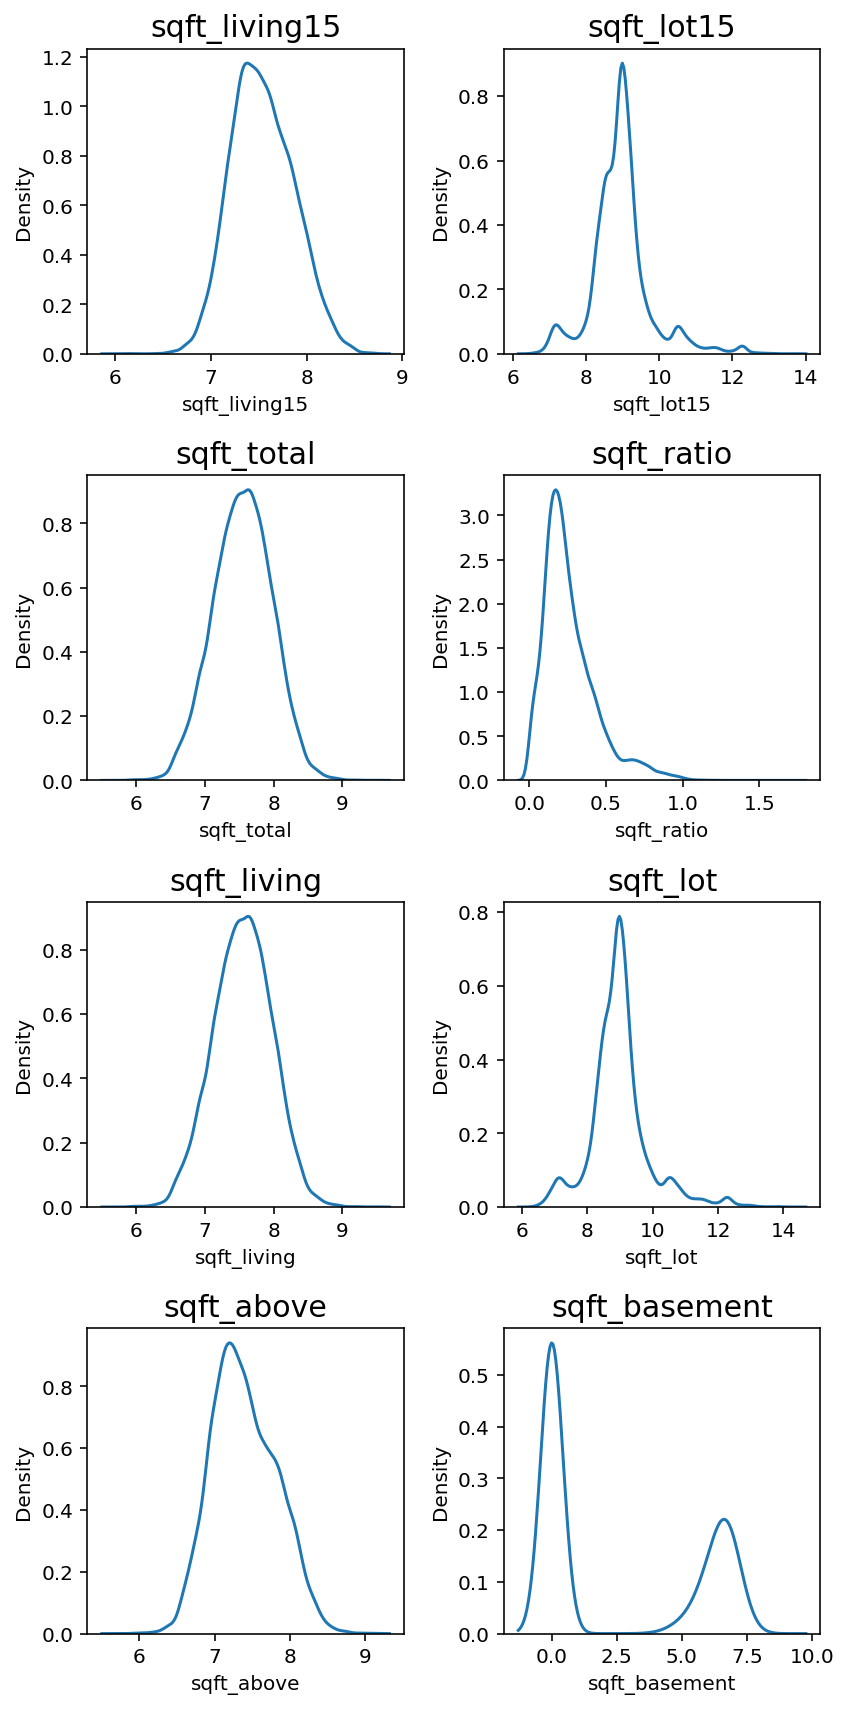

In [61]:
fig, ax = plt.subplots(4, 2, figsize=(6, 12))

count = 0
for row in range(4):
    for col in range(2):
        if count == 8:
            break
        sns.kdeplot(data[scalling_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(scalling_columns[count], fontsize=15)
        count += 1
plt.tight_layout()
plt.show()

로그함수의 특징은 다음과 같습니다.
- 0 < x < 1 범위에서는 기울기가 매우 가파릅니다. 즉, x의 구간은 (0,1)로 매우 짧은 반면, y의 구간은 (−∞,0)으로 매우 큽니다.
- 따라서 0에 가깝게 모여있는 값들이 x로 입력되면, 그 함수값인 y 값들은 매우 큰 범위로 벌어지게 됩니다. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가집니다.
- 반면, x값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아집니다. 이는 곧 큰 x값들에 대해서는 y값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 x를 비교적 작은 y값의 구간 내에 모이게 하는 특징을 가집니다.
위와 같은 특성 때문에 한 쪽으로 몰려있는 분포에 로그 변환을 취하게 되면 넓게 퍼질 수 있는 것이죠.

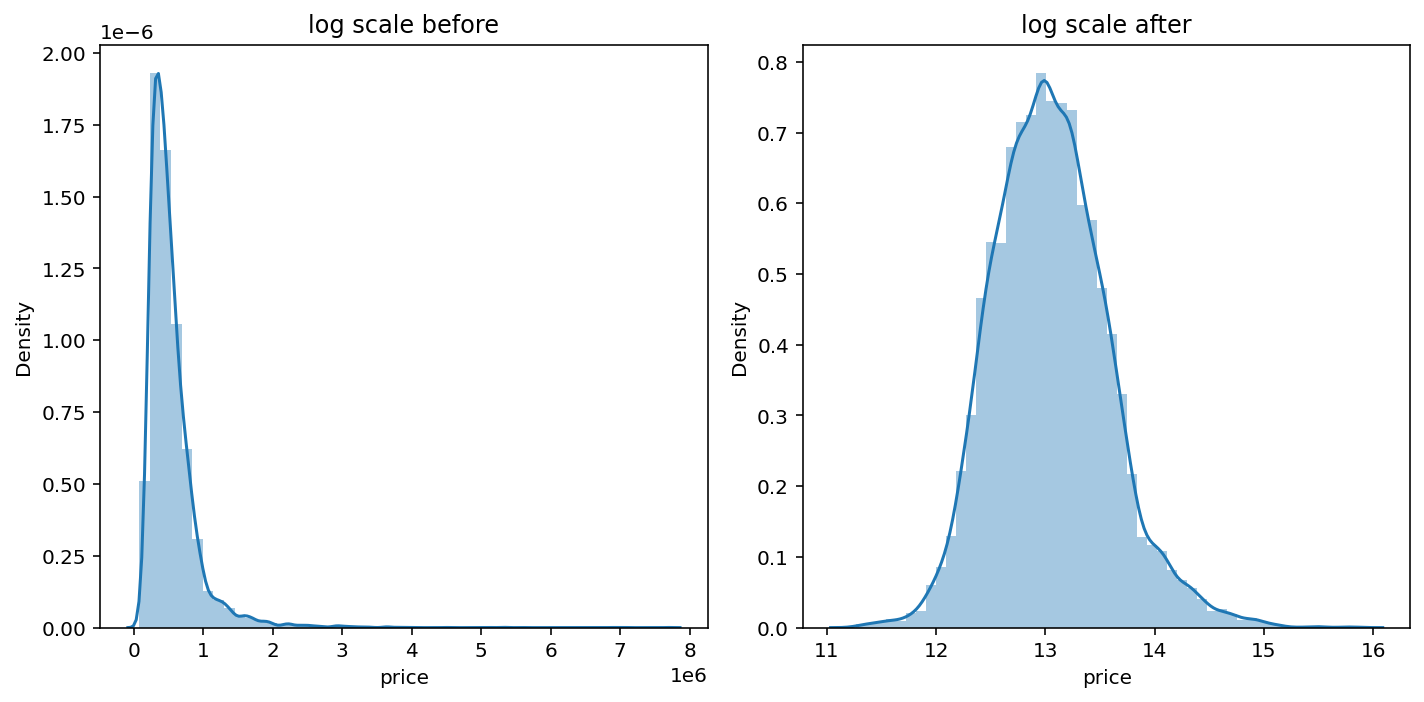

In [62]:
fig = plt.figure(figsize = (10,5))

fig.add_subplot(1,2,1)
res = sns.distplot(y)
plt.title("log scale before")

fig.add_subplot(1,2,2)
res = sns.distplot(np.log1p(y))
plt.title("log scale after")

y = np.log1p(y)

plt.tight_layout()
plt.show()

위의 목적변수의 경우 첨도, 왜도도 굉장히 정규분포를 따르지않고, 분산 또한 매우 큰 것을 확인할 수 있었습니다. 저는 회귀모델을 사용할 것이기 때문에 Normalize를 통해 price의 분포가 정규분포를 가지도록 만들어 주었습니다.

### 4. 변수간의 상관계수 시각화

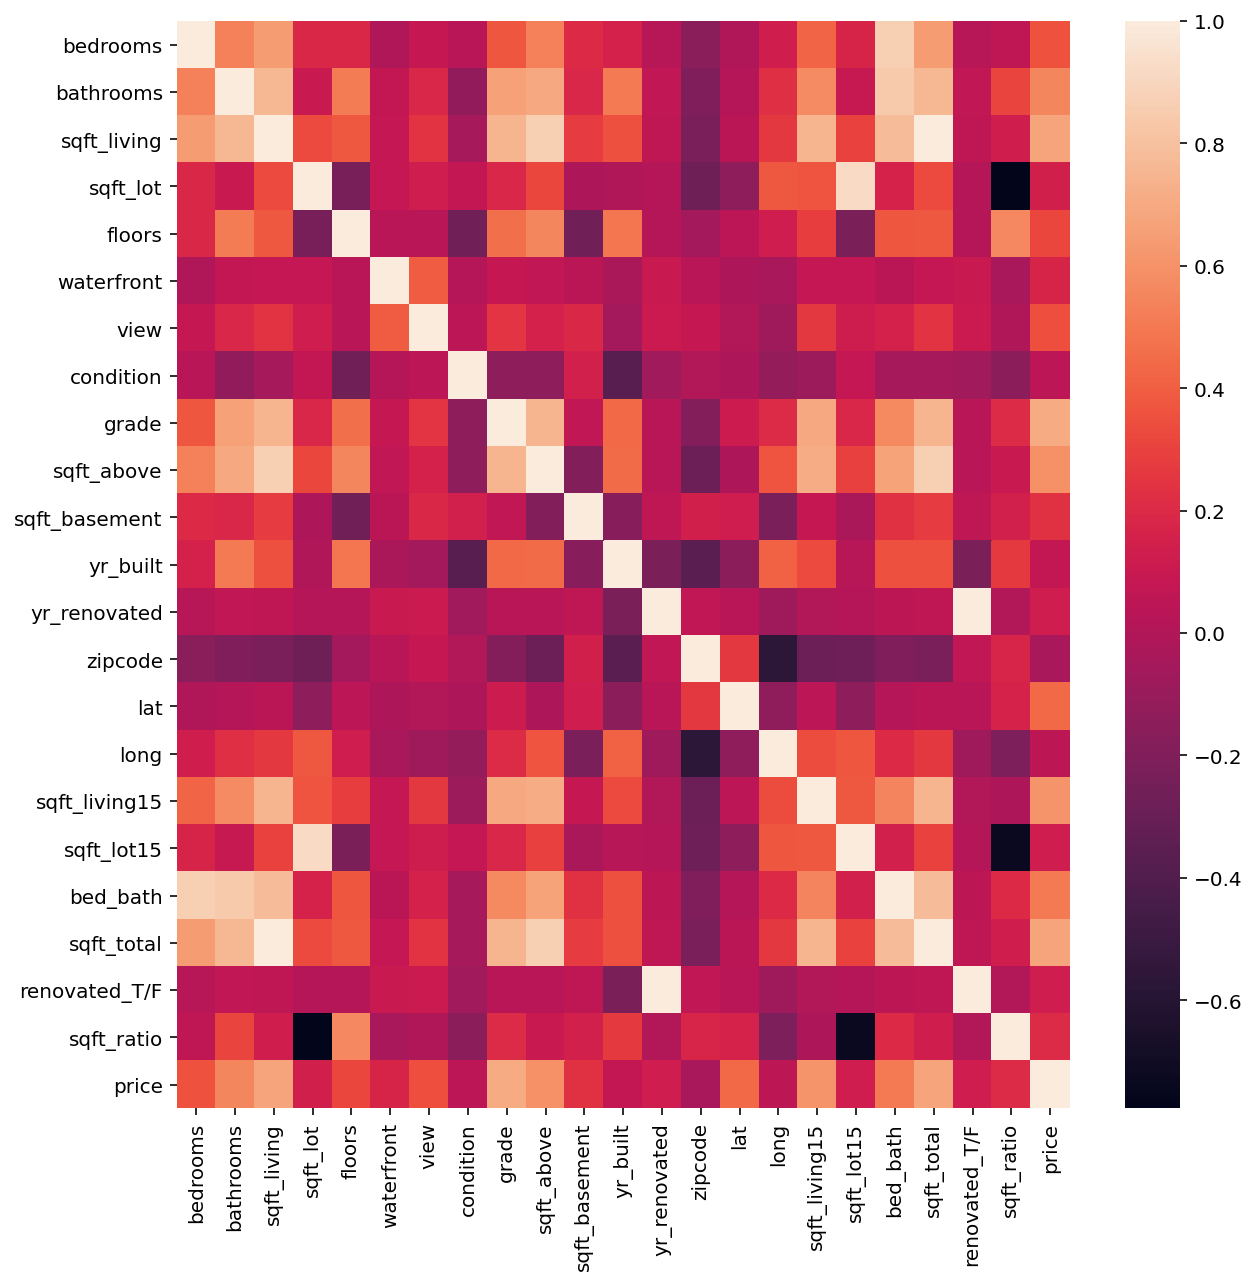

In [65]:
corr = pd.concat([data.iloc[:train_len,:], y], axis = 1)
plt.figure(figsize = (10, 10))
sns.heatmap(corr.corr())
plt.show()

눈에 띄는 상관관계는 sqft_ratio와 sqft_lot, sqt_lot15로 sqft_ratio는 sqft_lot에서 나온 파생변수이기 때문에 관련성이 높은 것은 당연한 결과로 보입니다.

### 5. 이상치 제거

이상치는 [링크](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12)를 참고하여 선택된 변수인 sqft_living, grade의 이상치들을 제거해보겠습니다.

In [72]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]
print(x.shape)
print(sub.shape)

(15035, 23)
(6468, 23)


#### sqft_living

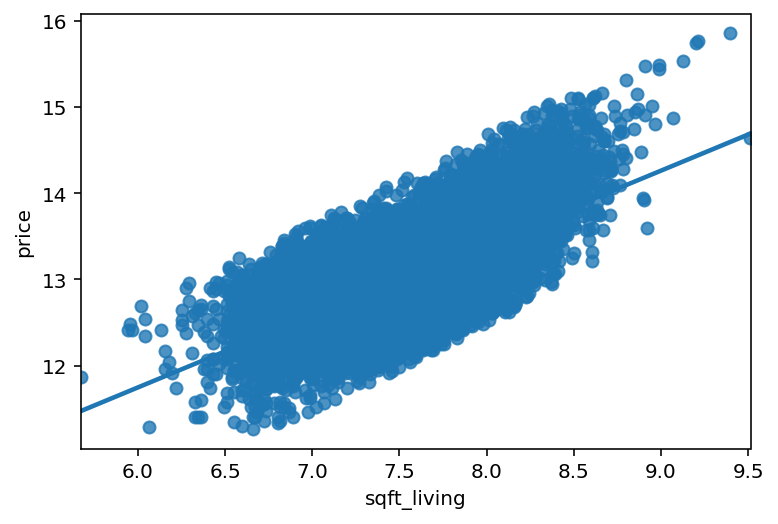

In [76]:
train = pd.concat([x, y], axis = 1)
sns.regplot(x = "sqft_living", y = "price", data = train)
plt.show()

In [81]:
train = train[train["sqft_living"] <= 9]

sqft_living을 시각화한 결과 다른 데이터들에 비해서 동떨어져 있는 데이터인 9 이상의 값들은 제거하겠습니다.

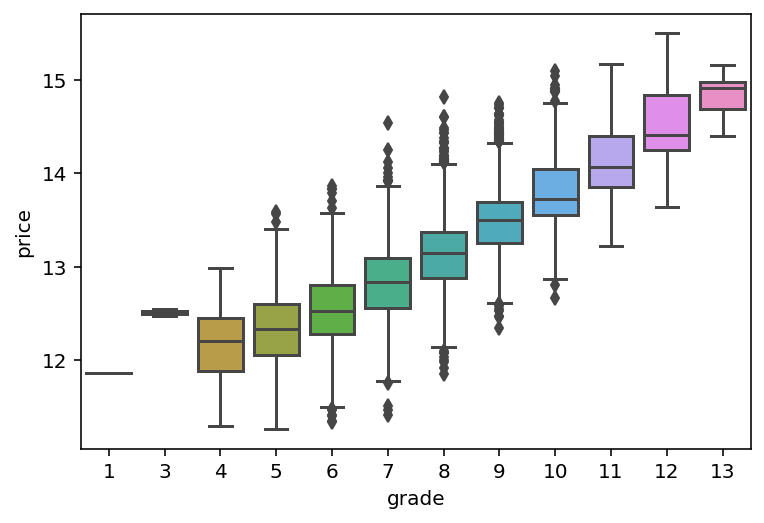

In [83]:
sns.boxplot(x = "grade", y = "price", data = train)
plt.show()

In [85]:
train.groupby("grade").count()["date"]

grade
1        1
3        2
4       23
5      174
6     1406
7     6228
8     4207
9     1855
10     781
11     287
12      60
13       5
Name: date, dtype: int64

In [86]:
train = train[(train["grade"] != 1) & (train["grade"] != 3) & (train["grade"] != 13)]

데이터 개수로 보았을 때 grade의 1, 3, 13은 모두 price가 너무 낮거나 너무 높게 책정되어 있고 그 개수가 다른 등급에 비해서 적기 때문에 제거해주겠습니다.

## 4. 모델 파이프라인 구축하기

In [91]:
train.shape, sub.shape

((15021, 24), (6468, 23))

In [92]:
x_train = train.drop(columns = ["price"])
y_train = train["price"]
x_test = sub

In [120]:
pipeline = Pipeline([
    ('model', 'passthrough')
])

params = [    
    {'model':(RandomForestRegressor(),),
     'model__n_estimators' : (100, 200, 300),
     'model__max_depth' : (3, 5, 7)
    },
    
    {'model':(GradientBoostingRegressor(),),
     'model__n_estimators' : (100, 200, 300),
     'model__learning_rate' : (0.05, 0.1, 0.15),
     'model__max_depth' : (3, 5, 7)
    },
    
    {'model':(XGBRegressor(),),
     'model__objective' : ['reg:linear'],
     'model__learning_rate' : (0.03, 0.05, 0.07),
     'model__max_depth' : (5, 6, 7),
     'model__child_weight' : [4],
     'model__silent' : [1],
     'model__subsample' : [0.7],
     'model__colsample_bytree' : [0.7],
     'model__n_estimators' : [500]
    },
    
    {'model':(LGBMRegressor(),),
     'model__boosting_type' : ('gbdt', 'dart'),
     'model__max_depth' : (5, 6, 7),
     'model__n_estimators' : (100, 200, 300),
     'model__learning_rate' : (0.05, 0.1, 0.15)
    }
]

In [121]:
grid_model = GridSearchCV(pipeline, 
                          params, 
                          scoring='neg_root_mean_squared_error',
                          verbose = 3, 
                          cv = 2, 
                          n_jobs = 2)
grid_model.fit(x_train, y_train)

Fitting 2 folds for each of 99 candidates, totalling 198 fits


GridSearchCV(cv=2, estimator=Pipeline(steps=[('model', 'passthrough')]),
             n_jobs=2,
             param_grid=[{'model': (RandomForestRegressor(),),
                          'model__max_depth': (3, 5, 7),
                          'model__n_estimators': (100, 200, 300)},
                         {'model': (GradientBoostingRegressor(max_depth=5,
                                                              n_estimators=300),),
                          'model__learning_rate': (0.05, 0.1, 0.15),
                          'model__max_depth': (3, 5, 7),
                          'model__n_estimators': (10...
                          'model__max_depth': (5, 6, 7),
                          'model__n_estimators': [500],
                          'model__objective': ['reg:linear'],
                          'model__silent': [1], 'model__subsample': [0.7]},
                         {'model': (LGBMRegressor(),),
                          'model__boosting_type': ('gbdt', 'dart'),
   

## 5. 모델 성능 확인하기

In [122]:
grid_model.cv_results_["mean_test_score"]

array([-0.2849648 , -0.28564487, -0.28527763, -0.237145  , -0.23601269,
       -0.23548289, -0.20715099, -0.20698676, -0.20707584, -0.19925506,
       -0.1830274 , -0.17724028, -0.17863504, -0.17131246, -0.1696027 ,
       -0.17367973, -0.17031947, -0.16981474, -0.18278431, -0.17468789,
       -0.17135537, -0.17305216, -0.16985599, -0.16904833, -0.17188493,
       -0.17148741, -0.17167222, -0.17844043, -0.17173954, -0.17019232,
       -0.17134838, -0.16926035, -0.16988531, -0.17425078, -0.17446975,
       -0.17478322,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

## 6. 완성된 결과 제출하기

In [123]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [124]:
y_pred = grid_model.predict(x_test)
y_pred = np.expm1(y_pred)
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.186443e+05
1,15036,4.632407e+05
2,15037,1.311013e+06
3,15038,3.035041e+05
4,15039,3.267921e+05


In [125]:
my_submission_path = join(data_dir, 'submission_outlier_new_params.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_outlier_new_params.csv
